# Improving LipSDP: Encoding ***Monotonocity*** of ReLU for a single layer NN

In [2]:
# importing necessary libraries
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Trivial Lipschitz constant (product of spectral norm)

In [3]:
def trivial(W0, W1):
    
    # computes 2-norm also known as Spectral norm
    
    norm_W0 = np.linalg.norm(W0, ord=2)
    norm_W1 = np.linalg.norm(W1, ord=2)
    lipschitz_constant = norm_W0 * norm_W1
    
    return lipschitz_constant

### Original LipSDP algorithm:

In [4]:
def lipsdp(W0, W1, alpha, beta):
    
    n = W0.shape[1]  # number of columns in W0 (hidden layer size)
    m = W1.shape[0]  # number of rows in W1 (number of neurons in the hidden layer)

    # defining the decision variables
    rho = cp.Variable(nonneg=True)
    diag_entries = cp.Variable(m, nonneg=True)
    T1 = cp.diag(diag_entries)
    
    # defining the matrix inequality M(ρ, Tm)
    M_upper_left = -2 * alpha * beta * (W0.T @ T1 @ W0) - rho * np.eye(W0.shape[0])
    M_upper_right = (alpha + beta) * (W0.T @ T1)
    M_lower_left = (alpha + beta) * (T1 @ W0)
    M_lower_right = -2 * T1 + W1.T @ W1

    # constructing the block matrix M(ρ, Tm)
    M = cp.bmat([
        [M_upper_left, M_upper_right],
        [M_lower_left, M_lower_right]
    ])

    # defining the constraints
    # M(ρ, Tm) is negative semidefinite and Tm has only positive diagonal entries
    constraints = [M << 0, diag_entries >= 0]

    # defining the objective function
    objective = cp.Minimize(rho)

    # defining the problem
    problem = cp.Problem(objective, constraints)
    
    # solving the problem
    problem.solve(solver=cp.SCS)  
    
    if problem.status not in ["infeasible", "unbounded"]:
        lipschitz_constant = np.sqrt(rho.value)
        return lipschitz_constant
    else:
        return None

## Monotonocity of ReLU and expressing using quadratic constraints:


Monotonocity condition expressed as an inequality: $(x-y)({\phi}(x) -{\phi}(y)) \geq 0$

This inequality when expressed using quadratic constraints translates as: 
 $ \begin{bmatrix} x-y \\ {\phi}(x) -{\phi}(y)  \end{bmatrix} ^\top \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x-y \\ {\phi}(x) -{\phi}(y)  \end{bmatrix} \geq 0 \tag{a}$

## How to encode this into the LipSDP algorithm? 
The setup is as following: 



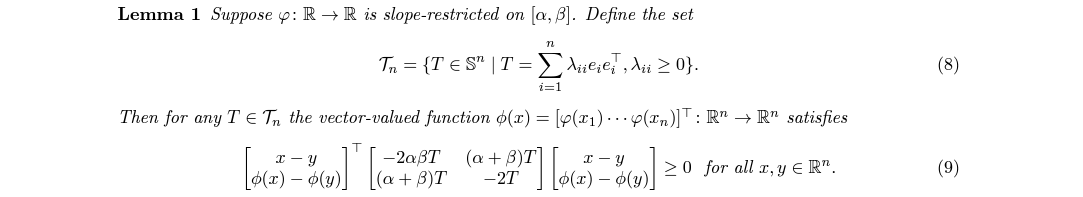

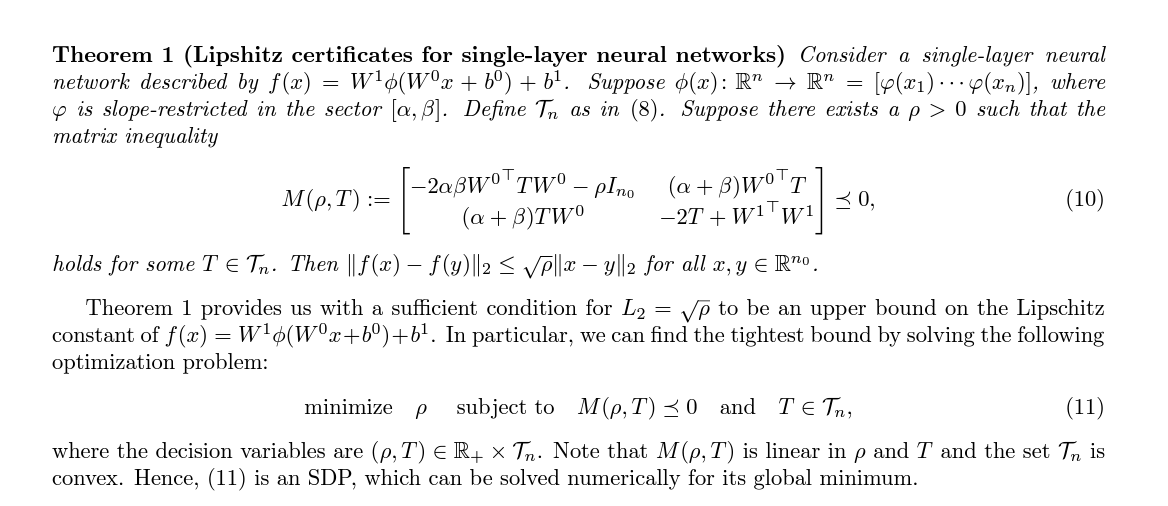

Details of the theorem and it's backgroud can be found in this paper: https://arxiv.org/abs/1906.04893v2
[Fazlyab, M., Robey, A., Hassani, H., Morari, M., & Pappas, G. J. (2019). Efficient and Accurate Estimation of Lipschitz Constants for Deep Neural Networks. ArXiv. /abs/1906.04893]

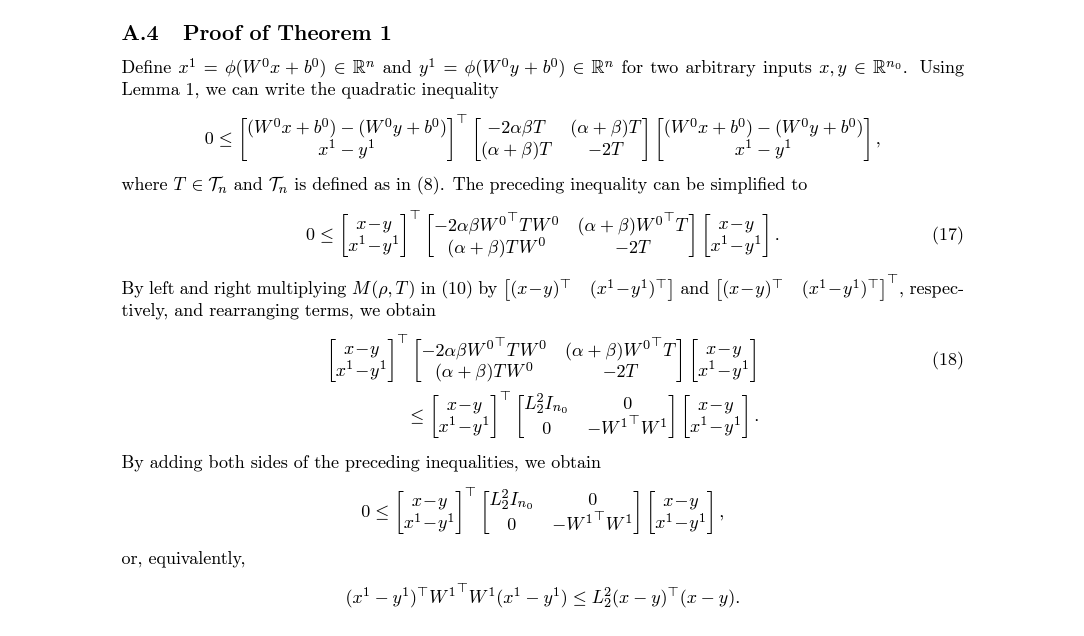

### We suggest the following way:
We introduce $T_{1}$, $T_{2}$ $\in \tau_{n}$. Here, $T_{1}$ represents $T$ in the original theorem, and $T_{2}$ has the same form as $T_{1}$ i.e. $T_{1}, T_{2} \in \tau_{n}$ as given in $(8)$. We then transform the inequality $(a)$ similar to $(17)$ while following the steps in using $T_{2}$ instead of $T \in \tau_{n} $  in Lemma 1. Following this, we add the inequalities
i.e. $(18)$ in and the one obtained from expressing monotonicity as a matrix inequality using quadratic constraints with the coefficients. This gives us the new matrix $M_{1}(\rho, T_{1}, T_{2})$ which follows the following condition:

\begin{equation}
   M_{1}(\rho, T_{1}, T_{2}) :=  \begin{bmatrix} -2\alpha\beta W^{0^T} T_{1}W^0 -\rho I_{n_{0}} & (\alpha+\beta)W^{0^T} T_{1} + W^{0^T}T_{2}
   \\ 
   (\alpha+\beta) T_{1}W^0 + T_{2}W^0  & -2T_{1} + W^{1^T} W^1 \end{bmatrix} 
   \preceq 0 \label{eq:m1}
\end{equation}

### Variant of LipSDP:

In [5]:
def lipsdp1(W0, W1, alpha, beta):
    
    n = W0.shape[1]  # number of columns in W0 (hidden layer size)
    m = W1.shape[0]  # number of rows in W1 (number of neurons in the hidden layer)

    # defining the decision variables
    rho = cp.Variable(nonneg=True)
    diag_entries1 = cp.Variable(m, nonneg=True)
    diag_entries2 = cp.Variable(m, nonneg=True)
    T1 = cp.diag(diag_entries1)
    T2 = cp.diag(diag_entries2)
    
    # defining the matrix inequality M(ρ, Tm)
    M2_upper_left = -2 * alpha * beta * (W0.T @ T1 @ W0) - rho * np.eye(W0.shape[0])
    M2_upper_right = (alpha + beta) * (W0.T @ T1) + (W0.T @ T2)
    M2_lower_left = (alpha + beta) * (T1 @ W0) + (T2 @ W0)
    M2_lower_right = -2 * T1 + W1.T @ W1

    # constructing the block matrix M(ρ, Tm)
    M2 = cp.bmat([
        [M2_upper_left, M2_upper_right],
        [M2_lower_left, M2_lower_right]
    ])

    # defining the constraints
    # M(ρ, Tm) is negative semidefinite and Tm has only positive diagonal entries
    constraints = [M2 << 0, diag_entries1 >= 0, diag_entries2 >= 0]

    # defining the objective function
    objective = cp.Minimize(rho)

    # defining the problem
    problem = cp.Problem(objective, constraints)
    
    # solving the problem
    problem.solve(solver=cp.SCS) 
    
    if problem.status not in ["infeasible", "unbounded"]:
        lipschitz_constant = np.sqrt(rho.value)
        return lipschitz_constant
    else:
        return None

In [6]:
alpha = 0.0  # setting alpha = 0
beta = 1.0   # setting beta = 1

In [7]:
# test case 1: 

# weight matrices are 2*2 identity matrices
W0 = np.array([[1, 0], [0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])

# computing the trivial Lipschitz constant
triv = trivial(W0, W1)

# computing the LipSDP Lipschitz constants
print(f"Trivial Lipschitz constant: {triv}")
print("Running LipSDP...")
l = lipsdp(W0, W1, alpha, beta)
print(f"Lipschitz constant computed using LipSDP: {l}")
l1 = lipsdp1(W0, W1, alpha, beta)
print(f"Lipschitz constant computed on using monotonicity constraints: {l1}")

Trivial Lipschitz constant: 1.0
Running LipSDP...
Lipschitz constant computed using LipSDP: 1.0000025938862902
Lipschitz constant computed on using monotonicity constraints: 1.0000037886452882


In [8]:
# test case 2:

# weight matrices are 3*3 identity matrices
W0 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 
W1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) 

# computing the trivial Lipschitz constant
triv = trivial(W0, W1)

# computing the LipSDP Lipschitz constants
print(f"Trivial Lipschitz constant: {triv}")
print("Running LipSDP...")
l = lipsdp(W0, W1, alpha, beta)
print(f"Lipschitz constant computed using LipSDP: {l}")
l1 = lipsdp1(W0, W1, alpha, beta)
print(f"Lipschitz constant computed on using monotonicity constraints: {l1}")

Trivial Lipschitz constant: 1.0
Running LipSDP...
Lipschitz constant computed using LipSDP: 1.00001518420924
Lipschitz constant computed on using monotonicity constraints: 1.0000000037218513


In [9]:
# test case 3:

# weight matrices are 4*4 identity matrices
W0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) 
W1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) 

# computing the trivial Lipschitz constant
triv = trivial(W0, W1)

# computing the LipSDP Lipschitz constants
print(f"Trivial Lipschitz constant: {triv}")
print("Running LipSDP...")
l = lipsdp(W0, W1, alpha, beta)
print(f"Lipschitz constant computed using LipSDP: {l}")
l1 = lipsdp1(W0, W1, alpha, beta)
print(f"Lipschitz constant computed on using monotonicity constraints: {l1}")

Trivial Lipschitz constant: 1.0
Running LipSDP...
Lipschitz constant computed using LipSDP: 1.0000004858875091
Lipschitz constant computed on using monotonicity constraints: 1.0000000093622563


In [16]:
# test case 4:

# weight matrices are random 2*2 matrices
W0 = np.random.rand(2, 2)
W1 = np.random.rand(2, 2) 

# computing the trivial Lipschitz constant
triv = trivial(W0, W1)

# computing the LipSDP Lipschitz constants
print(f"Trivial Lipschitz constant: {triv}")
print("Running LipSDP...")
l = lipsdp(W0, W1, alpha, beta)
print(f"Lipschitz constant computed using LipSDP: {l}")
l1 = lipsdp1(W0, W1, alpha, beta)
print(f"Lipschitz constant computed on using monotonicity constraints: {l1}")

Trivial Lipschitz constant: 1.2888510690406807
Running LipSDP...
Lipschitz constant computed using LipSDP: 1.2556943897785189
Lipschitz constant computed on using monotonicity constraints: 1.2556943351912586


### Evaluating the above LipSDP algorithm variant on encoding the monotonocity constraints: 

In [97]:
# iterating over random testcases
iter = 100
lip_triv = 0 # counter for when LipSDP gives tighter estimation than trivial bound
lip1_triv = 0 # counter for when LipSDP1 gives tighter estimation than the trivial bound
lip1_lip = 0 # counter for when LipSDP1 gives tighter estimation than LipSDP


for iteration in range(iter):
    
    # random 2*2 weight matrices

    W0 = np.random.rand(2, 2)
    W1 = np.random.rand(2, 2)
    
    # computing LipSDP Lipschitz constants and evaluating the results
    l = lipsdp(W0, W1, alpha, beta)
    l1 = lipsdp1(W0, W1, alpha, beta)
    triv = trivial(W0, W1)
    if l1<l:
        lip1_lip+=1
    if l<triv:
        lip_triv+=1
    if l1<triv:
        lip1_triv+=1
    
print(f"% of testcases where LipSDP gives a tighter bound than the trivial one: {(lip_triv/iter)*100}")
print(f"% of testcases where LipSDP1 gives a tighter bound than the trivial one: {(lip1_triv/iter)*100}")
print(f"% of testcases where LipSDP1 gives a tighter bound than LipSDP: {(lip1_lip/iter)*100}")

% of testcases where LipSDP gives a tighter bound than the trivial one: 100.0
% of testcases where LipSDP1 gives a tighter bound than the trivial one: 100.0
% of testcases where LipSDP1 gives a tighter bound than LipSDP: 59.0


**Conclusion:** The variant of LipSDP gives a tighter bound than the trivial one and works better than the original LipSDP algorithm in about 50-70% of the cases